<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Stacked Charts**


Estimated time needed: **45** minutes


In this lab, you will focus on visualizing data specifically using stacked charts. You will use SQL queries to extract the necessary data and apply stacked charts to analyze the composition and comparison within the data.


## Objectives


In this lab, you will perform the following:


- Visualize the composition of data using stacked charts.

- Compare multiple variables across different categories using stacked charts.

- Analyze trends within stacked chart visualizations.


## Setup: Downloading and Loading the Data
**Install the libraries**


In [ ]:
!pip install pandas

In [ ]:
!pip install matplotlib


**Download and Load the Data**


To start, download and load the dataset into a `pandas` DataFrame.



### Step 1: Download the dataset


In [1]:
!wget -O survey-data.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/n01PQ9pSmiRX6520flujwQ/survey-data.csv

--2026-01-01 23:27:14--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/n01PQ9pSmiRX6520flujwQ/survey-data.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159525875 (152M) [text/csv]
Saving to: ‘survey-data.csv’

survey-data.csv     100%[===================>] 152.13M   131MB/s    in 1.2s    

2026-01-01 23:27:15 (131 MB/s) - ‘survey-data.csv’ saved [159525875/159525875]



### Step 2: Import necessary libraries and load the dataset


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Load the data


In [3]:
df = pd.read_csv("survey-data.csv")

### Display the first few rows of the data to understand its structure


In [4]:
df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV (Lab 19 uses survey-data.csv)
df = pd.read_csv("survey-data.csv")

# ---------- helpers ----------
def to_num(s):
    return pd.to_numeric(s, errors="coerce")

AGE_ORDER = [
    "Under 18 years old",
    "18-24 years old",
    "25-34 years old",
    "35-44 years old",
    "45-54 years old",
    "55-64 years old",
    "65 years or older",
    "Prefer not to say"
]

def order_age_index(idx):
    # keep only known ages, in a stable order
    return [a for a in AGE_ORDER if a in idx]

def explode_multiselect(series):
    s = series.dropna().astype(str).str.split(";").explode().str.strip()
    s = s[s.ne("")]
    return s

def verify_nonempty(d, cols, name):
    print(f"\n--- VERIFY {name} ---")
    missing = [c for c in cols if c not in d.columns]
    if missing:
        raise KeyError(f"Missing columns: {missing}")
    print(d[cols].notna().sum())
    d2 = d.dropna(subset=cols)
    print("Rows after dropna:", len(d2))
    return d2

# ---------- clean once ----------
dfc = df.copy()

# Numeric satisfaction points
for c in ["JobSatPoints_6", "JobSatPoints_7", "JobSat"]:
    if c in dfc.columns:
        dfc[c] = to_num(dfc[c])

# Money
if "ConvertedCompYearly" in dfc.columns:
    dfc["ConvertedCompYearly"] = to_num(dfc["ConvertedCompYearly"])
    # drop impossible values (prevents crazy scales / empty after filtering)
    dfc.loc[(dfc["ConvertedCompYearly"] <= 0) | (dfc["ConvertedCompYearly"] > 5_000_000), "ConvertedCompYearly"] = np.nan

print("dfc shape:", dfc.shape)


dfc shape: (65437, 114)


### Task 1: Stacked Chart for Composition of Job Satisfaction Across Age Groups


##### 1. Stacked Chart of Median `JobSatPoints_6` and `JobSatPoints_7` for Different Age Groups


Visualize the composition of job satisfaction scores (`JobSatPoints_6` and `JobSatPoints_7`) across various age groups. This will help in understanding the breakdown of satisfaction levels across different demographics.




--- VERIFY Task 1.1 ---
Age               65437
JobSatPoints_6    29450
JobSatPoints_7    29448
dtype: int64
Rows after dropna: 29424


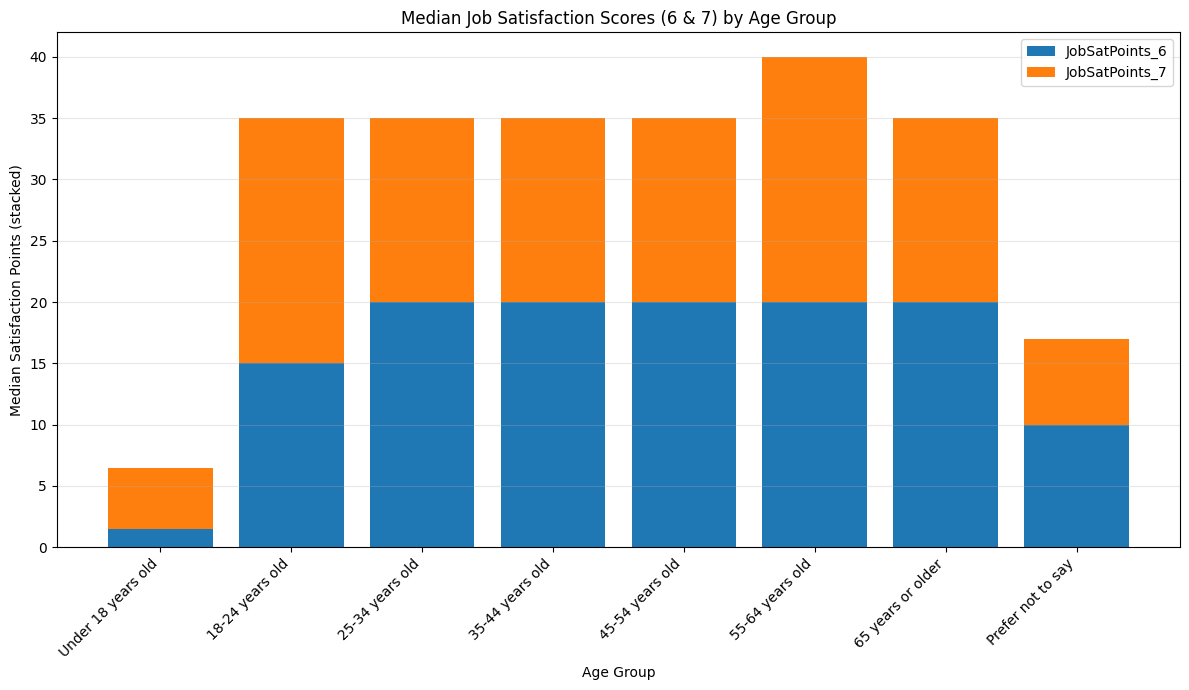

                    JobSatPoints_6  JobSatPoints_7
Age                                               
Under 18 years old             1.5             5.0
18-24 years old               15.0            20.0
25-34 years old               20.0            15.0
35-44 years old               20.0            15.0
45-54 years old               20.0            15.0
55-64 years old               20.0            20.0
65 years or older             20.0            15.0
Prefer not to say             10.0             7.0


In [6]:
d = verify_nonempty(dfc, ["Age", "JobSatPoints_6", "JobSatPoints_7"], "Task 1.1")

sat_by_age = (
    d.groupby("Age")[["JobSatPoints_6", "JobSatPoints_7"]]
    .median()
)

# reorder age groups
sat_by_age = sat_by_age.reindex(order_age_index(sat_by_age.index))

plt.figure(figsize=(12,7))
plt.bar(sat_by_age.index, sat_by_age["JobSatPoints_6"], label="JobSatPoints_6")
plt.bar(
    sat_by_age.index,
    sat_by_age["JobSatPoints_7"],
    bottom=sat_by_age["JobSatPoints_6"],
    label="JobSatPoints_7"
)

plt.title("Median Job Satisfaction Scores (6 & 7) by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Median Satisfaction Points (stacked)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(sat_by_age)


##### Stacked Chart of `JobSatPoints_6` and `JobSatPoints_7` for Employment Status


Create a stacked chart to compare job satisfaction (`JobSatPoints_6` and `JobSatPoints_7`) across different employment statuses. This will show how satisfaction varies by employment type.



--- VERIFY Task 1.2 ---
Employment        65437
JobSatPoints_6    29450
JobSatPoints_7    29448
dtype: int64
Rows after dropna: 29424


/tmp/ipython-input-544041717.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


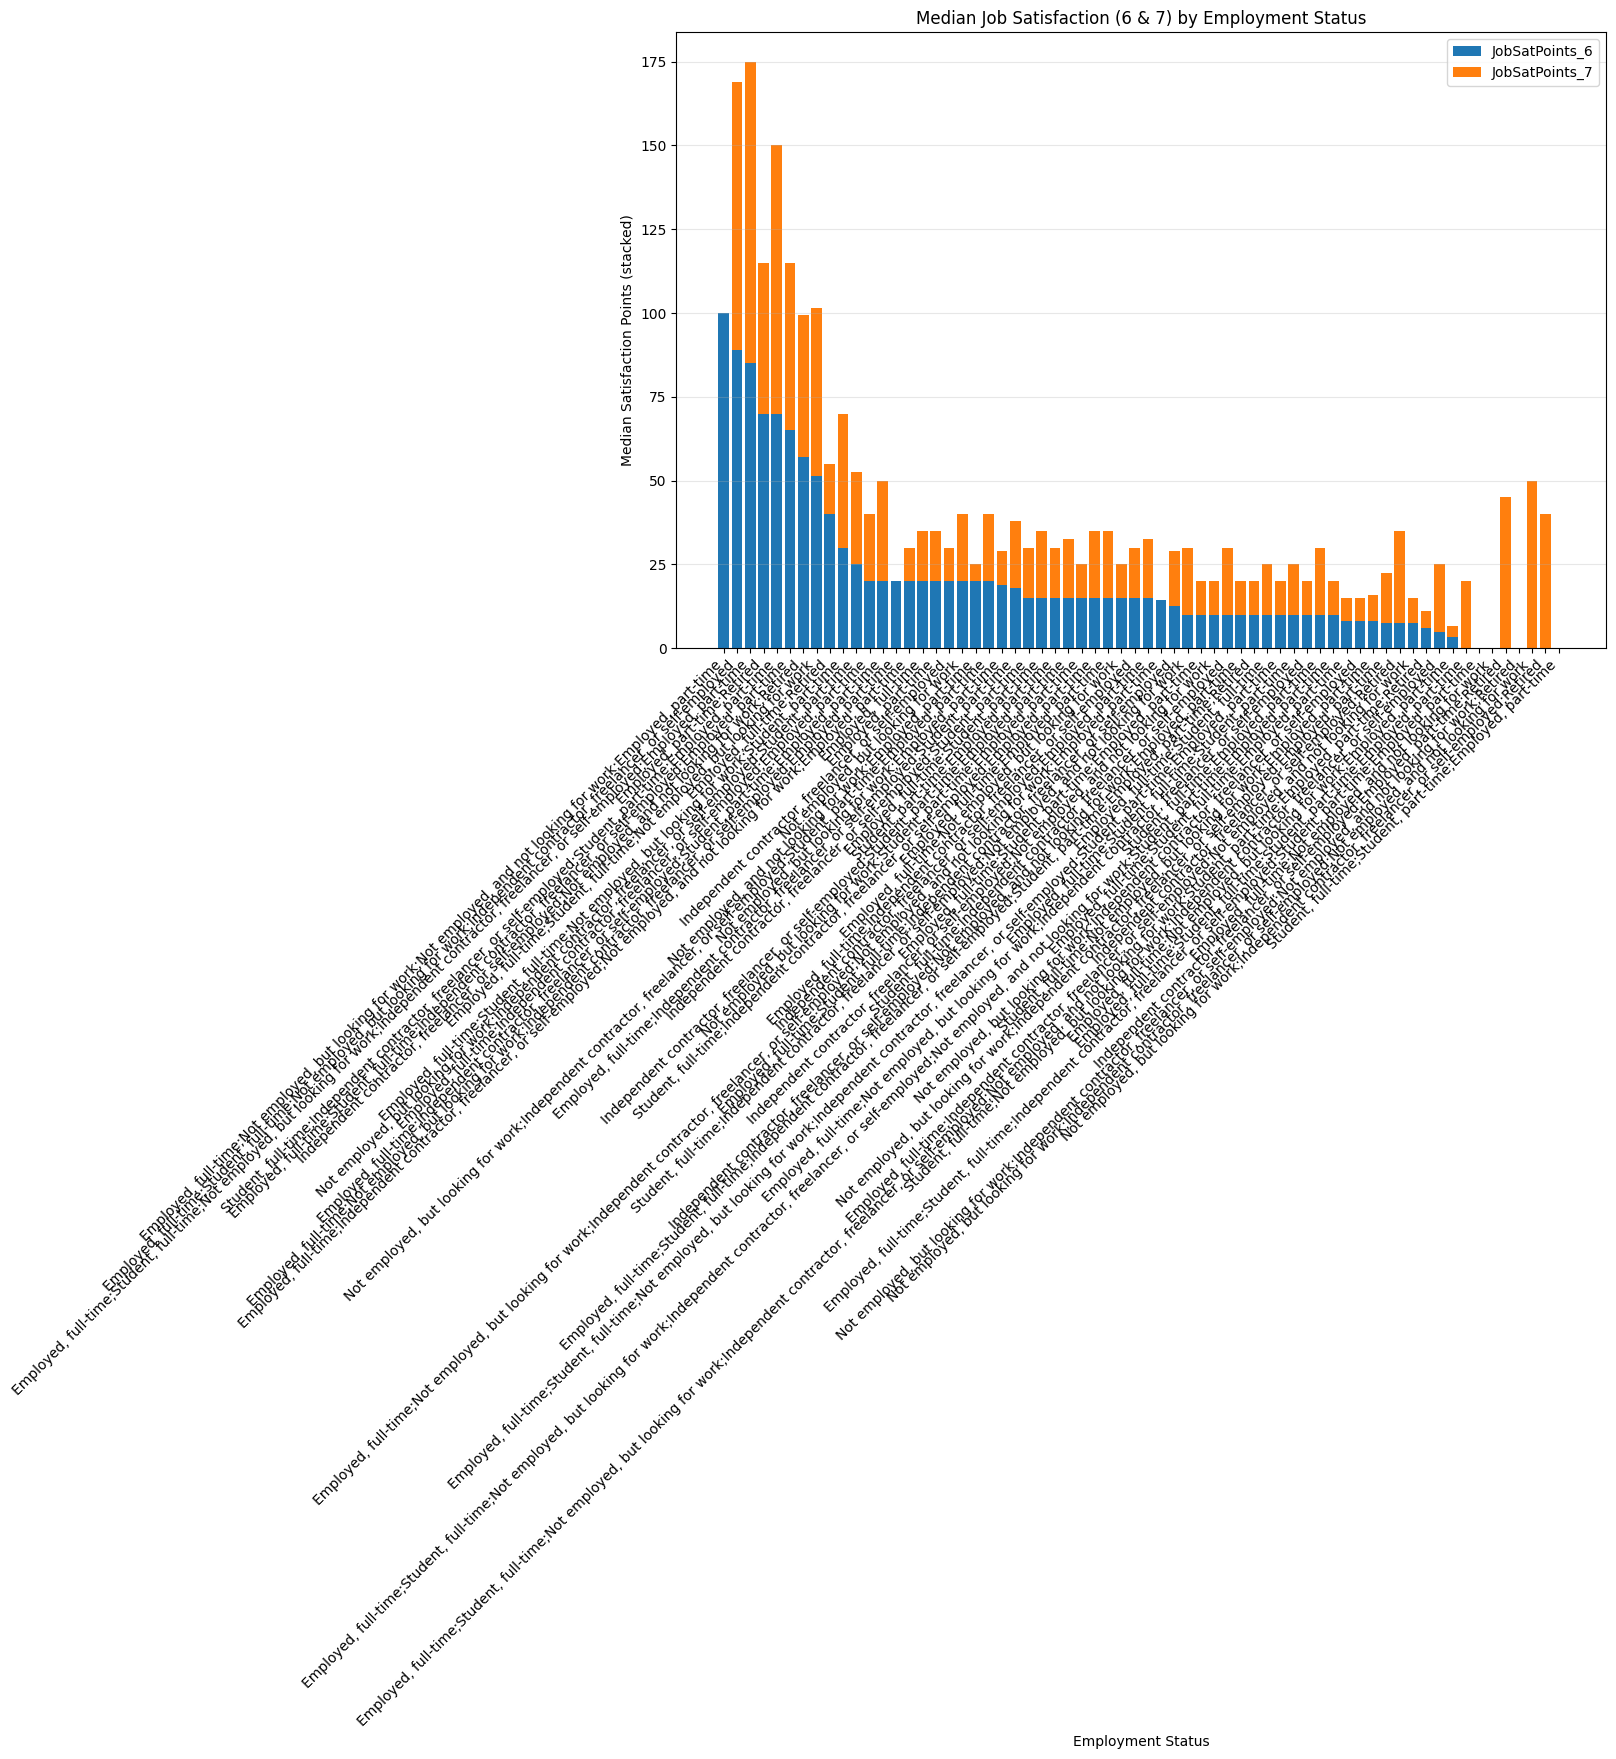

                                                    JobSatPoints_6  \
Employment                                                           
Employed, full-time;Not employed, but looking f...           100.0   
Employed, full-time;Student, full-time;Not empl...            89.0   
Employed, full-time;Student, full-time;Not empl...            85.0   
Employed, part-time;Retired                                   70.0   
Student, full-time;Independent contractor, free...            70.0   
...                                                            ...   
Independent contractor, freelancer, or self-emp...             0.0   
Not employed, but looking for work;Independent ...             0.0   
Not employed, but looking for work;Independent ...             0.0   
Not employed, but looking for work;Independent ...             0.0   
Student, full-time;Student, part-time;Employed,...             0.0   

                                                    JobSatPoints_7  
Employment          

In [7]:
d = verify_nonempty(dfc, ["Employment", "JobSatPoints_6", "JobSatPoints_7"], "Task 1.2")

employment_sat = (
    d.groupby("Employment")[["JobSatPoints_6", "JobSatPoints_7"]]
    .median()
    .sort_values("JobSatPoints_6", ascending=False)
)

plt.figure(figsize=(12,8))
plt.bar(employment_sat.index, employment_sat["JobSatPoints_6"], label="JobSatPoints_6")
plt.bar(
    employment_sat.index,
    employment_sat["JobSatPoints_7"],
    bottom=employment_sat["JobSatPoints_6"],
    label="JobSatPoints_7"
)

plt.title("Median Job Satisfaction (6 & 7) by Employment Status")
plt.xlabel("Employment Status")
plt.ylabel("Median Satisfaction Points (stacked)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(employment_sat)


### Task 2: Stacked Chart for Compensation and Job Satisfaction by Age Group


##### This stacked chart visualizes the composition of compensation (`ConvertedCompYearly`) and job satisfaction (`JobSatPoints_6`) specifically for respondents aged 30-35.


In [14]:
grouped = d_age.groupby("Age")[["ConvertedCompYearly", "JobSatPoints_6"]].median()


In [15]:
norm = (grouped - grouped.min()) / (grouped.max() - grouped.min())


Rows in age bin: 7430
Median ConvertedCompYearly: 59872.0
Median JobSatPoints_6: 20.0


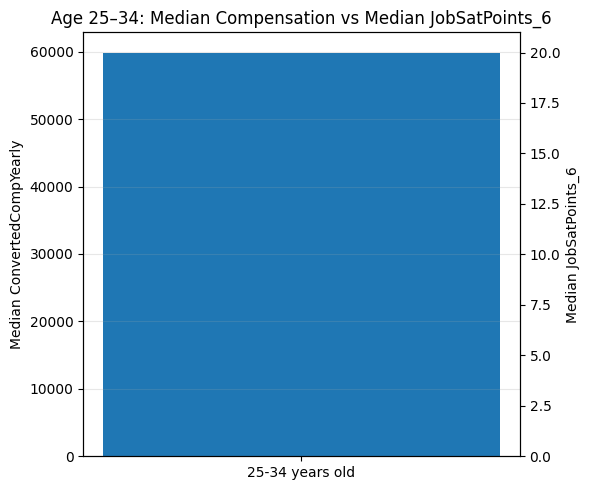

In [16]:
# Task 2.1 FIX: show raw medians with two axes (still stacked concept)

d = dfc.dropna(subset=["Age", "ConvertedCompYearly", "JobSatPoints_6"]).copy()
d = d[d["ConvertedCompYearly"].between(1, 5_000_000)]

age_bin = "25-34 years old"   # closest bin to 30–35
d_age = d[d["Age"] == age_bin]

print("Rows in age bin:", len(d_age))

med_comp = d_age["ConvertedCompYearly"].median()
med_sat  = d_age["JobSatPoints_6"].median()

print("Median ConvertedCompYearly:", med_comp)
print("Median JobSatPoints_6:", med_sat)

fig, ax1 = plt.subplots(figsize=(6,5))

# bar for compensation on left axis
ax1.bar([age_bin], [med_comp], label="Median ConvertedCompYearly")
ax1.set_ylabel("Median ConvertedCompYearly")
ax1.set_title("Age 25–34: Median Compensation vs Median JobSatPoints_6")

# second axis for JobSatPoints_6
ax2 = ax1.twinx()
ax2.bar([age_bin], [med_sat], alpha=0.4, label="Median JobSatPoints_6")
ax2.set_ylabel("Median JobSatPoints_6")

ax1.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


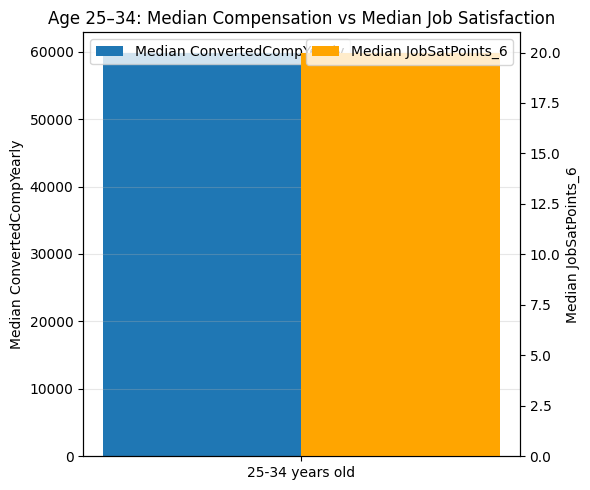

In [17]:
fig, ax1 = plt.subplots(figsize=(6,5))

x = [0]  # numeric position

# Left axis bar
ax1.bar([x[0] - 0.15], [med_comp], width=0.3, label="Median ConvertedCompYearly")
ax1.set_ylabel("Median ConvertedCompYearly")

# Right axis bar
ax2 = ax1.twinx()
ax2.bar([x[0] + 0.15], [med_sat], width=0.3, color="orange", label="Median JobSatPoints_6")
ax2.set_ylabel("Median JobSatPoints_6")

ax1.set_xticks(x)
ax1.set_xticklabels([age_bin])

ax1.set_title("Age 25–34: Median Compensation vs Median Job Satisfaction")
ax1.grid(axis="y", alpha=0.3)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


For respondents aged 25–34, median compensation is about $60,000 per year, while median job satisfaction is around 20 points. This shows that early-career professionals earn moderate salaries with mid-range satisfaction.

##### Stacked Chart of Median Compensation and Job Satisfaction Across Age Group


Compare the median compensation and job satisfaction metrics across different age groups. This helps visualize how compensation and satisfaction levels differ by age.



--- VERIFY Task 2.2 ---
Age                    65437
ConvertedCompYearly    23431
JobSatPoints_6         29450
dtype: int64
Rows after dropna: 16182


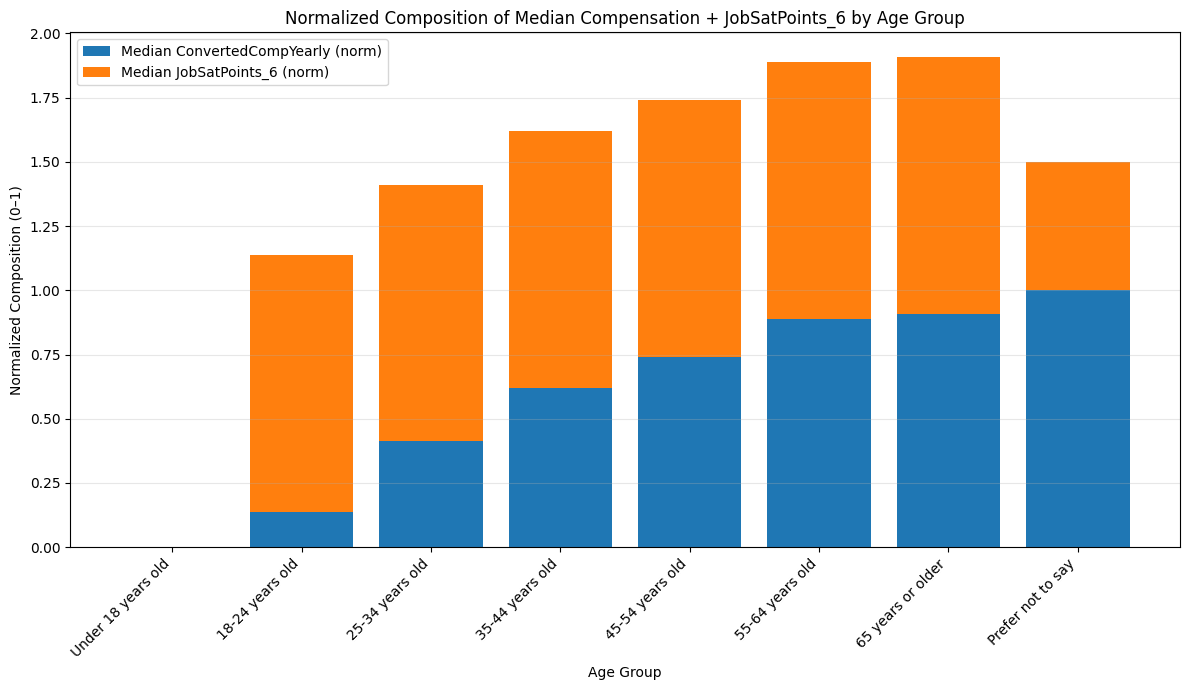

Raw medians:
                     ConvertedCompYearly  JobSatPoints_6
Age                                                    
Under 18 years old               8661.0            10.0
18-24 years old                 25666.0            20.0
25-34 years old                 59872.0            20.0
35-44 years old                 85925.0            20.0
45-54 years old                100900.5            20.0
55-64 years old                119189.5            20.0
65 years or older              121668.0            20.0
Prefer not to say              133023.5            15.0


In [18]:
d = verify_nonempty(dfc, ["Age", "ConvertedCompYearly", "JobSatPoints_6"], "Task 2.2")

median_data = d.groupby("Age")[["ConvertedCompYearly", "JobSatPoints_6"]].median()
median_data = median_data.reindex(order_age_index(median_data.index))

normalized = (median_data - median_data.min()) / (median_data.max() - median_data.min())
normalized = normalized.fillna(0)

plt.figure(figsize=(12,7))
plt.bar(normalized.index, normalized["ConvertedCompYearly"], label="Median ConvertedCompYearly (norm)")
plt.bar(
    normalized.index,
    normalized["JobSatPoints_6"],
    bottom=normalized["ConvertedCompYearly"],
    label="Median JobSatPoints_6 (norm)"
)

plt.title("Normalized Composition of Median Compensation + JobSatPoints_6 by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Normalized Composition (0–1)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("Raw medians:\n", median_data)


### Task 3: Comparing Data Using Stacked Charts


##### 1. Stacked Chart of Preferred Databases by Age Group




Visualize the top databases that respondents from different age groups wish to learn. Create a stacked chart to show the proportion of each database in each age group.



--- VERIFY Task 3.1 ---
Age                       65437
DatabaseWantToWorkWith    42558
dtype: int64
Rows after dropna: 42558


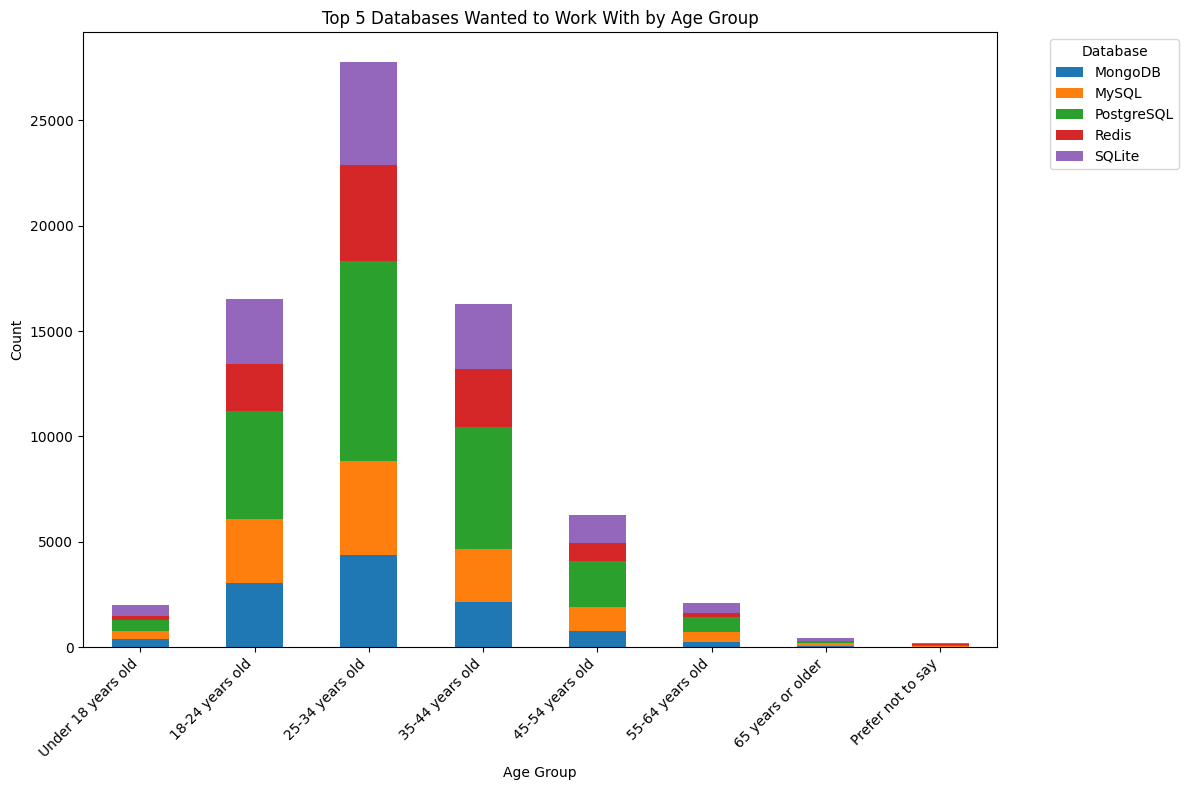

Database            MongoDB  MySQL  PostgreSQL  Redis  SQLite
Age                                                          
Under 18 years old      374    411         506    209     508
18-24 years old        3027   3077        5113   2235    3052
25-34 years old        4363   4465        9523   4542    4897
35-44 years old        2140   2536        5769   2779    3060
45-54 years old         773   1125        2201    865    1293


In [20]:
d = verify_nonempty(dfc, ["Age", "DatabaseWantToWorkWith"], "Task 3.1")

tmp = d[["Age", "DatabaseWantToWorkWith"]].dropna().copy()
tmp["Database"] = tmp["DatabaseWantToWorkWith"].astype(str).str.split(";")
tmp = tmp.explode("Database")
tmp["Database"] = tmp["Database"].astype(str).str.strip()
tmp = tmp[tmp["Database"].ne("")]

# top 5 overall
top5 = tmp["Database"].value_counts().head(5).index.tolist()
tmp = tmp[tmp["Database"].isin(top5)]

pivot_df = tmp.groupby(["Age", "Database"]).size().unstack(fill_value=0)
pivot_df = pivot_df.reindex(order_age_index(pivot_df.index))

pivot_df.plot(kind="bar", stacked=True, figsize=(12,8))
plt.title("Top 5 Databases Wanted to Work With by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Database", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

print(pivot_df.head())

##### 2. Stacked Chart of Employment Type by Job Satisfaction


Analyze the distribution of employment types within each job satisfaction level using a stacked chart. This will provide insights into how employment types are distributed across various satisfaction ratings.



--- VERIFY Task 3.2 ---
JobSat        29126
Employment    65437
dtype: int64
Rows after dropna: 29126


/tmp/ipython-input-2889209233.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


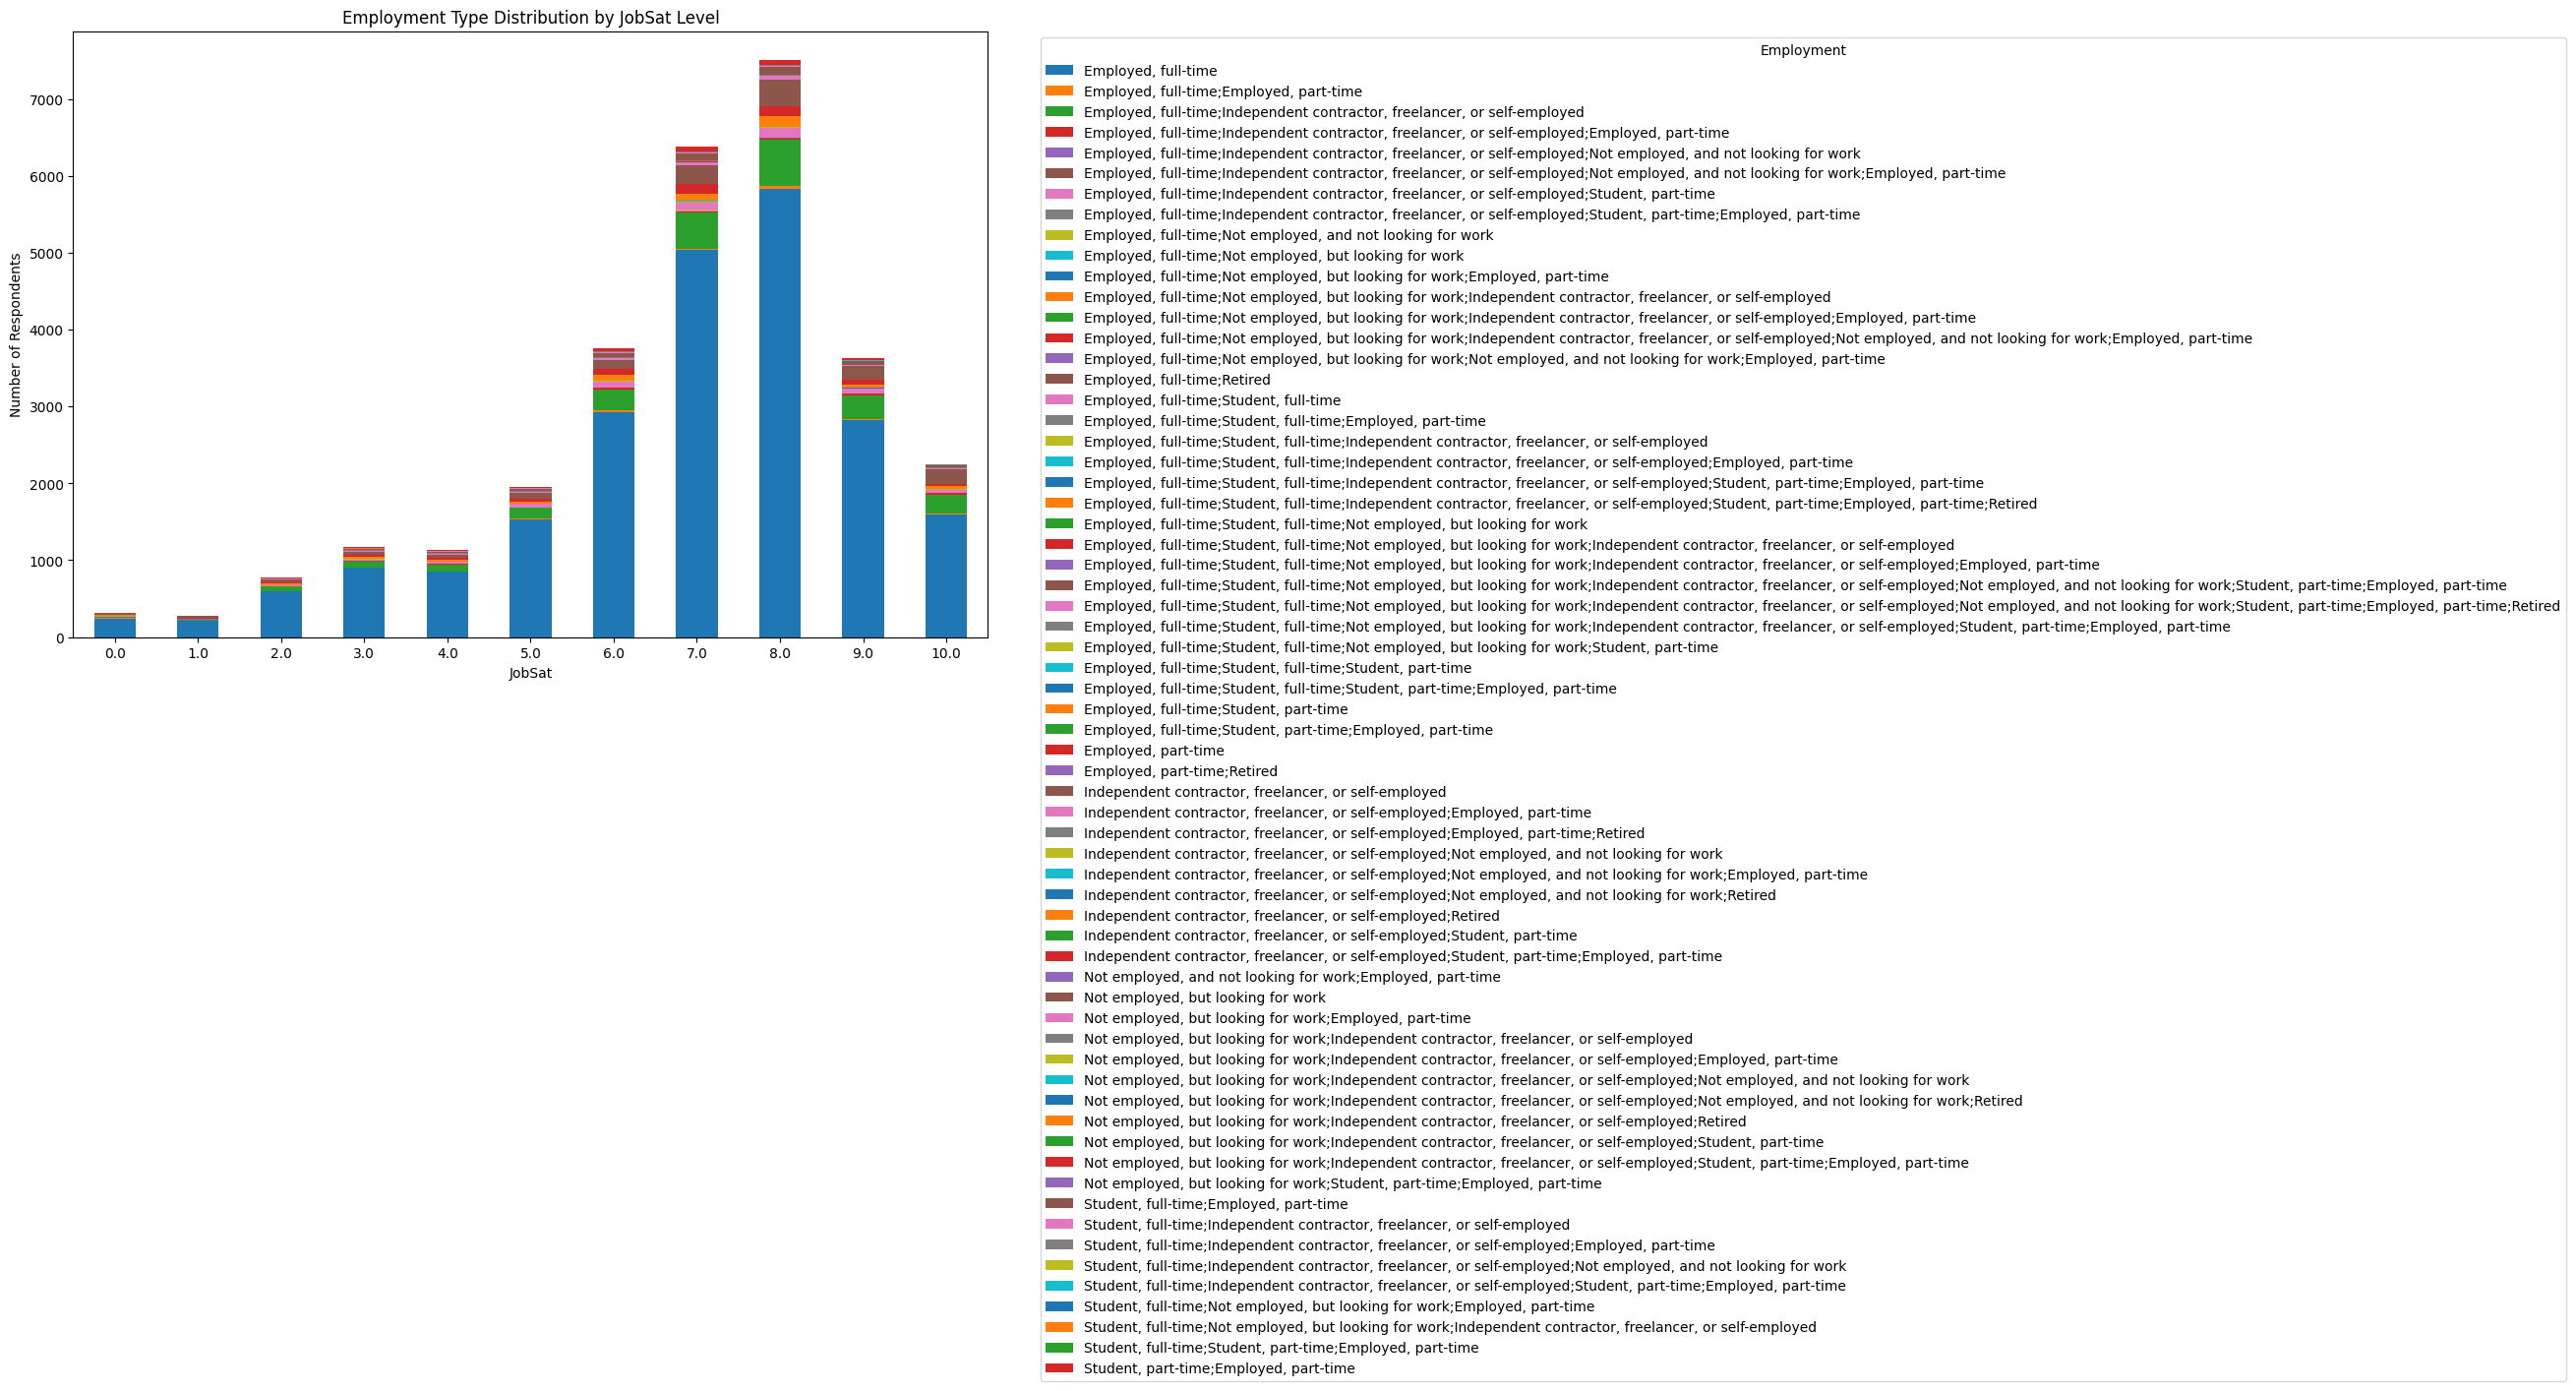

In [24]:
d = verify_nonempty(dfc, ["JobSat", "Employment"], "Task 3.2")

dist = d.groupby(["JobSat", "Employment"]).size().unstack(fill_value=0)

# sort JobSat numeric
dist = dist.sort_index()

dist.plot(kind="bar", stacked=True, figsize=(12,8))
plt.title("Employment Type Distribution by JobSat Level")
plt.xlabel("JobSat")
plt.ylabel("Number of Respondents")
plt.xticks(rotation=0)
plt.legend(title="Employment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



### Task 4: Exploring Technology Preferences Using Stacked Charts


##### 1. Stacked Chart for Preferred Programming Languages by Age Group


Analyze how programming language preferences (`LanguageAdmired`) vary across age groups.



--- VERIFY Task 4.1 ---
Age                65437
LanguageAdmired    50872
dtype: int64
Rows after dropna: 50872


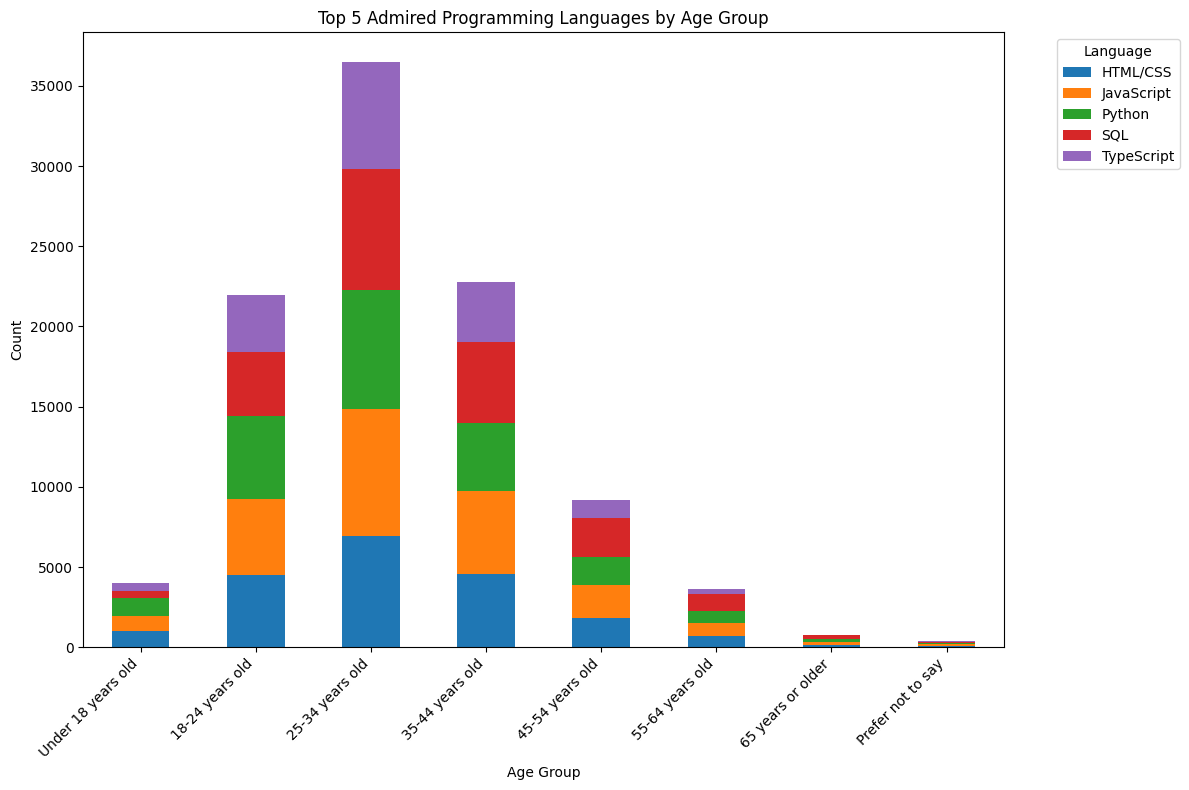

In [25]:
d = verify_nonempty(dfc, ["Age", "LanguageAdmired"], "Task 4.1")

tmp = d[["Age", "LanguageAdmired"]].dropna().copy()
tmp["Language"] = tmp["LanguageAdmired"].astype(str).str.split(";")
tmp = tmp.explode("Language")
tmp["Language"] = tmp["Language"].astype(str).str.strip()
tmp = tmp[tmp["Language"].ne("")]

top5 = tmp["Language"].value_counts().head(5).index.tolist()
tmp = tmp[tmp["Language"].isin(top5)]

pivot_df = tmp.groupby(["Age", "Language"]).size().unstack(fill_value=0)
pivot_df = pivot_df.reindex(order_age_index(pivot_df.index))

pivot_df.plot(kind="bar", stacked=True, figsize=(12,8))
plt.title("Top 5 Admired Programming Languages by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


##### 2. Stacked Chart for Technology Adoption by Employment Type


Explore how admired platforms (`PlatformAdmired`) differ across employment types (e.g., full-time, freelance)



--- VERIFY Task 4.2 ---
Employment         65437
PlatformAdmired    31377
dtype: int64
Rows after dropna: 31377


/tmp/ipython-input-2450393992.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


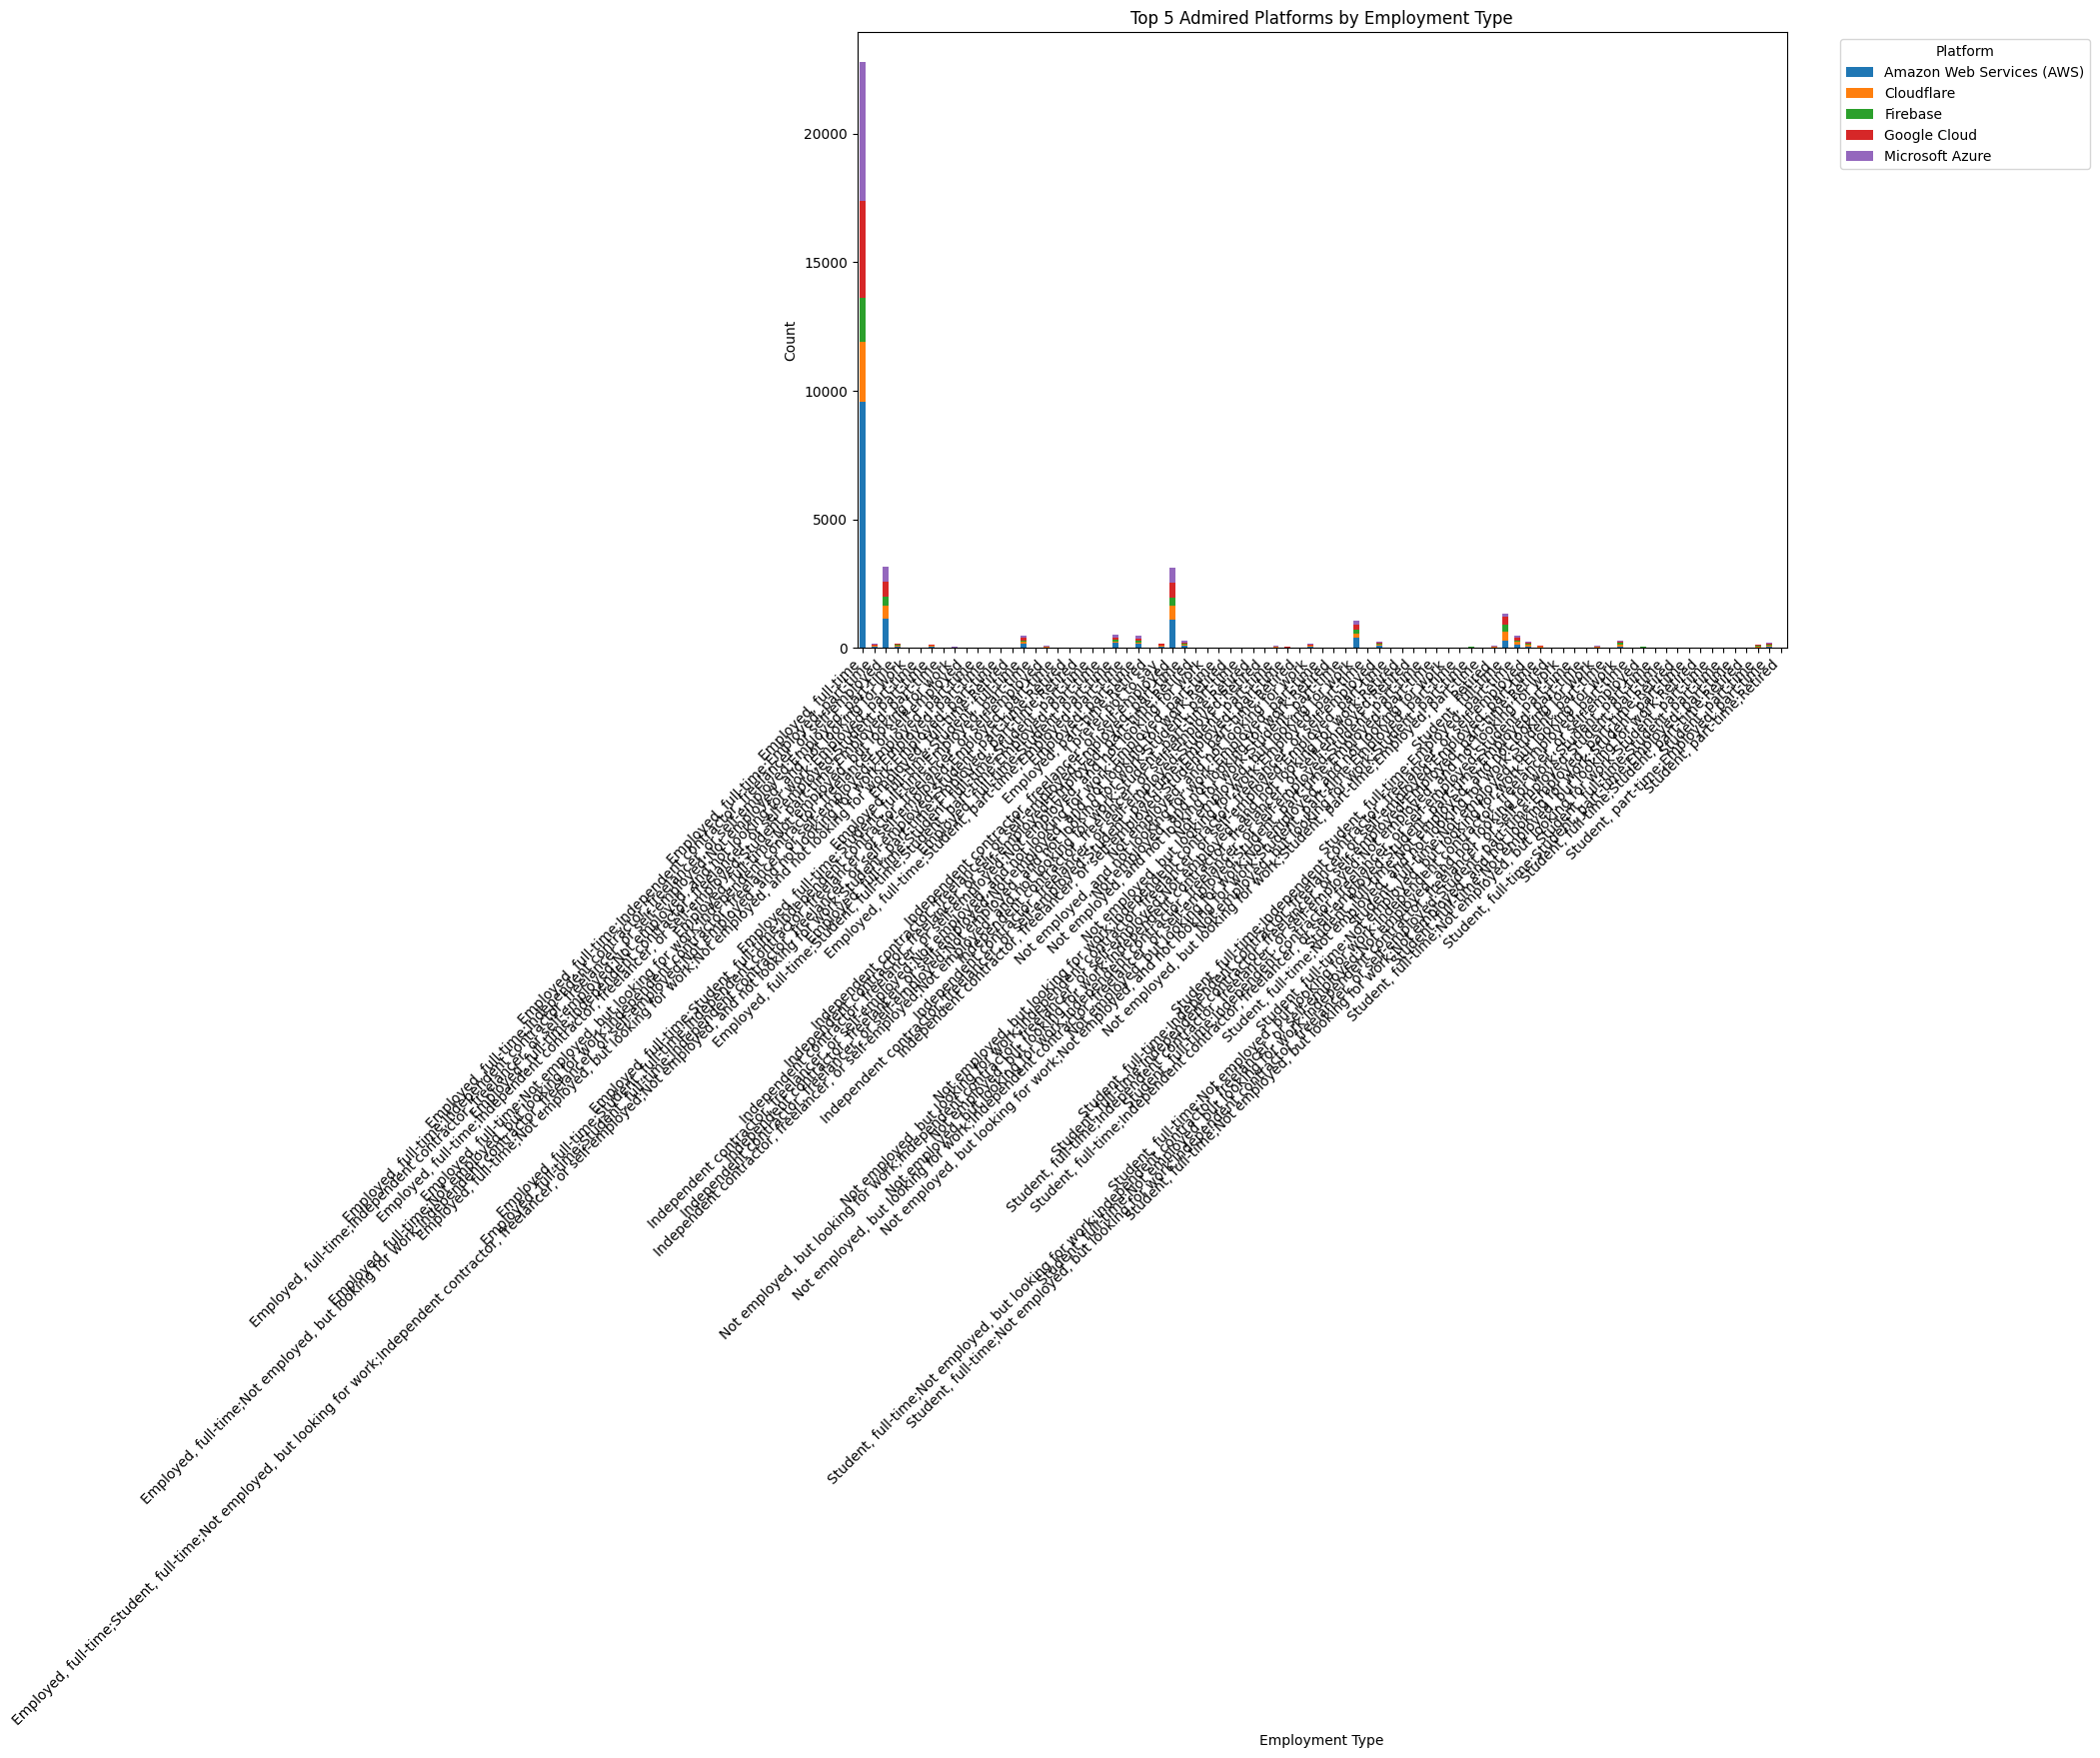

In [26]:
d = verify_nonempty(dfc, ["Employment", "PlatformAdmired"], "Task 4.2")

tmp = d[["Employment", "PlatformAdmired"]].dropna().copy()
tmp["Platform"] = tmp["PlatformAdmired"].astype(str).str.split(";")
tmp = tmp.explode("Platform")
tmp["Platform"] = tmp["Platform"].astype(str).str.strip()
tmp = tmp[tmp["Platform"].ne("")]

top5 = tmp["Platform"].value_counts().head(5).index.tolist()
tmp = tmp[tmp["Platform"].isin(top5)]

pivot_df = tmp.groupby(["Employment", "Platform"]).size().unstack(fill_value=0)

pivot_df.plot(kind="bar", stacked=True, figsize=(12,8))
plt.title("Top 5 Admired Platforms by Employment Type")
plt.xlabel("Employment Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Final Step: Review


In this lab, you focused on using stacked charts to understand the composition and comparison within the dataset. Stacked charts provided insights into job satisfaction, compensation, and preferred databases across age groups and employment types.


## Summary


After completing this lab, you will be able to:

- Use stacked charts to analyze the composition of data across categories, such as job satisfaction and compensation by age group.

- Compare data across different dimensions using stacked charts, enhancing your ability to communicate complex relationships in the data.

- Visualize distributions across multiple categories, such as employment type by satisfaction, to gain a deeper understanding of patterns within the dataset.


## Author:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


<!--
## Change Log
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2024-10-28|1.2|Madhusudhan Moole|Updated lab|
|2024-10-16|1.1|Madhusudhan Moole|Updated lab|
|2024-10-15|1.0|Raghul Ramesh|Created lab|
--!>


Copyright © IBM Corporation. All rights reserved.
